Running Gradient Descent...


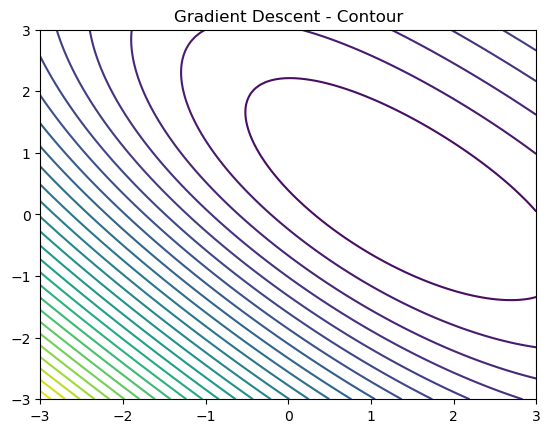

C:\Users\23adsb51\.conda\envs\61782323110051\lib\site-packages\matplotlib\animation.py:872: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


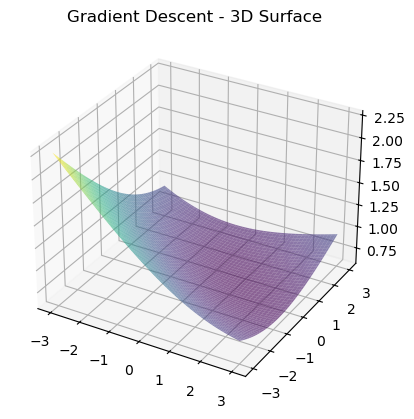

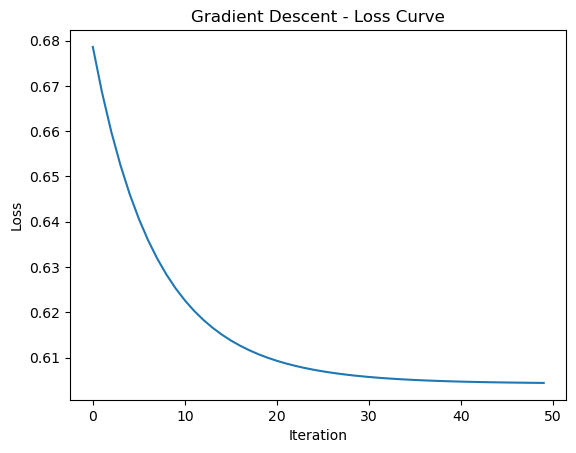

Running SGD...


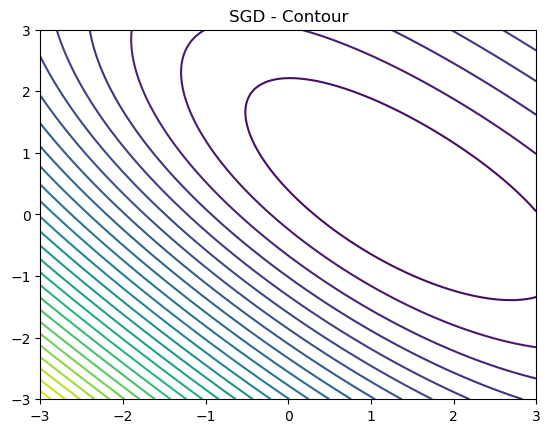

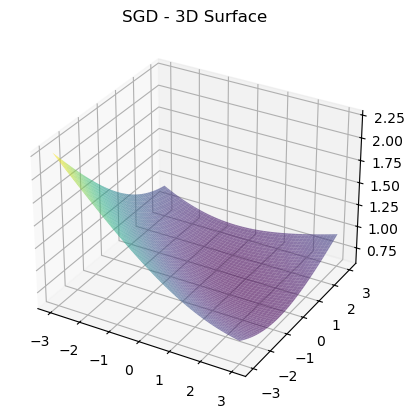

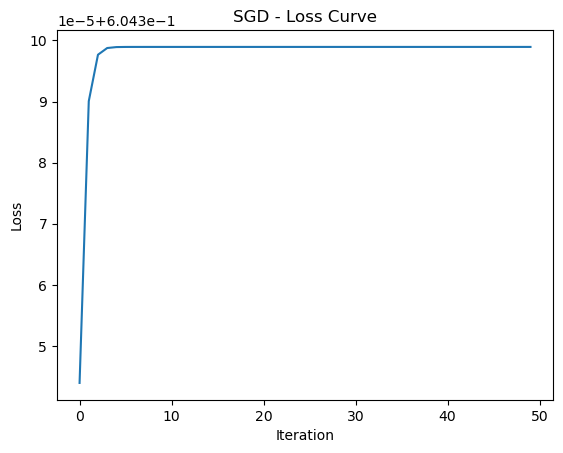

Running Mini-Batch GD...


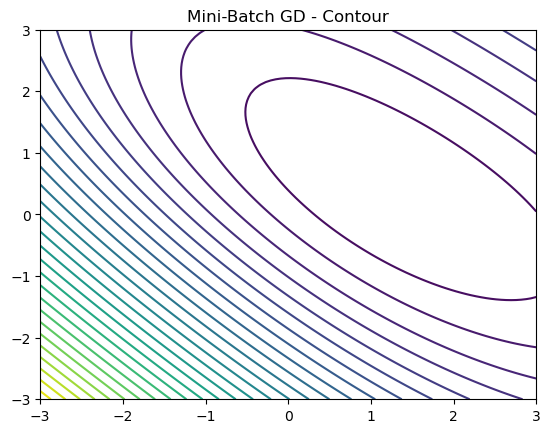

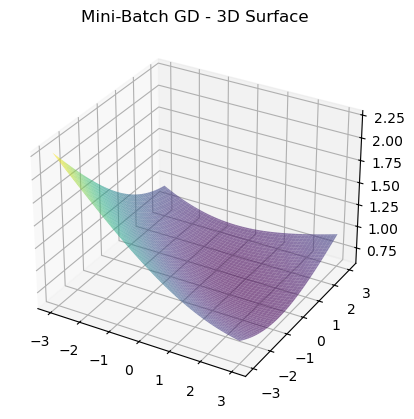

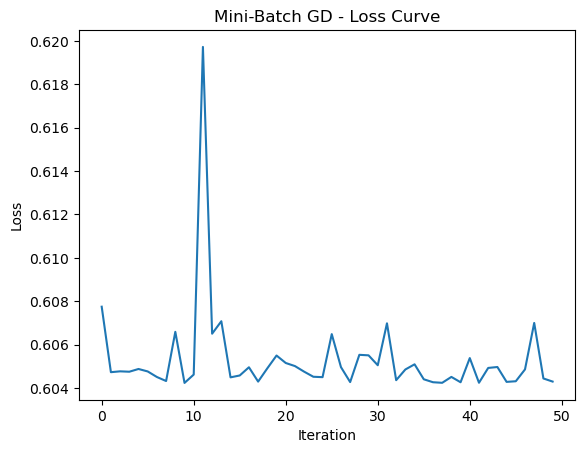

Running Nesterov...


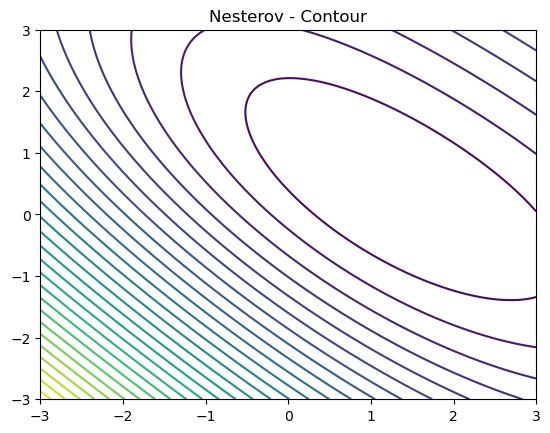

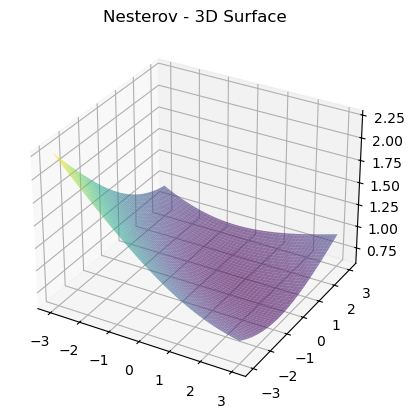

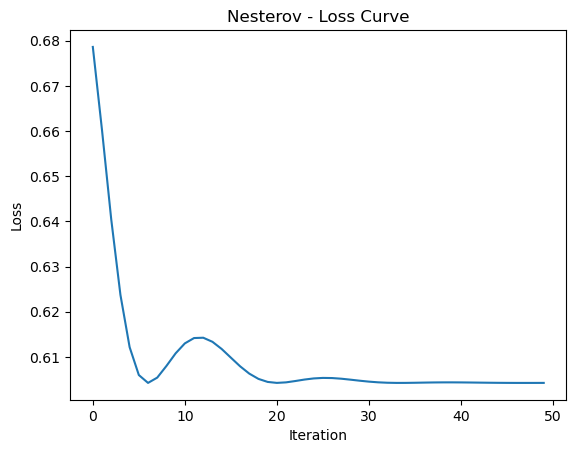

Running Adagrad...


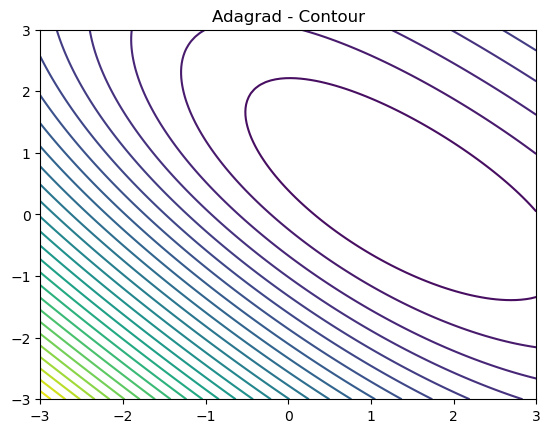

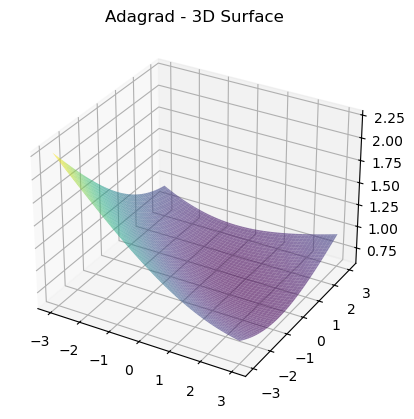

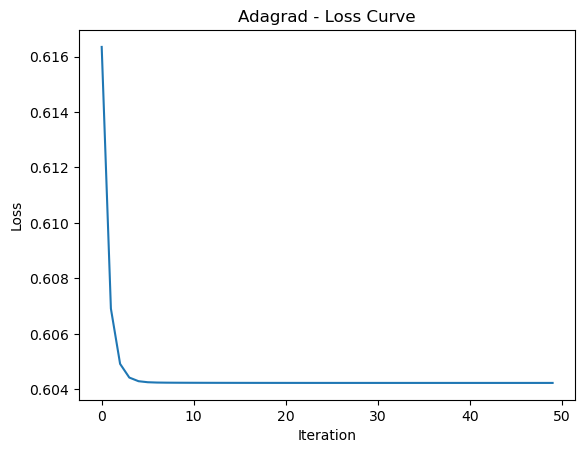

Running RMSProp...


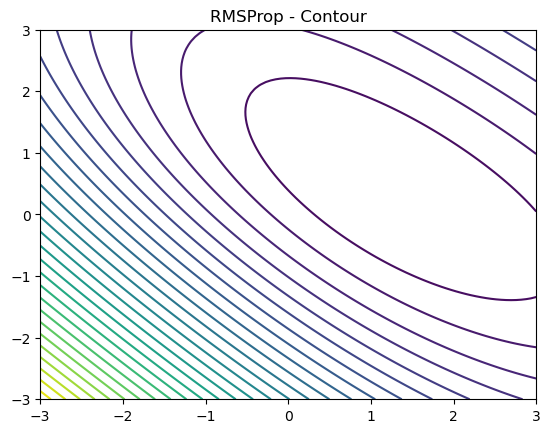

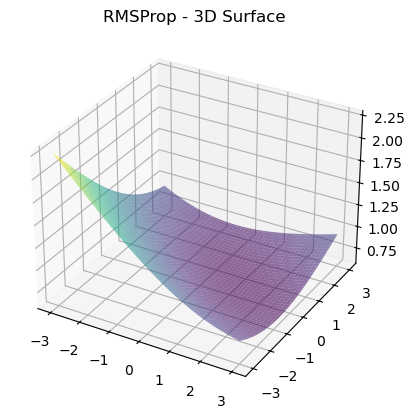

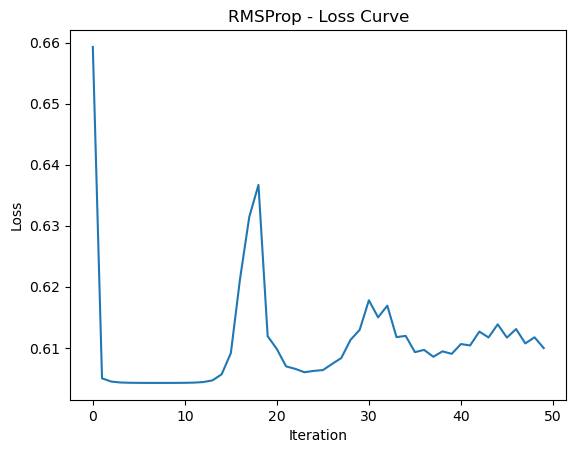

Running Adam...


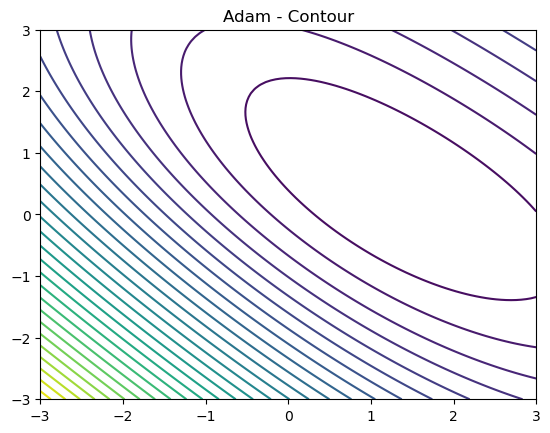

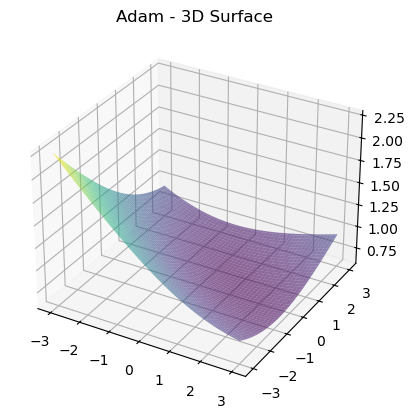

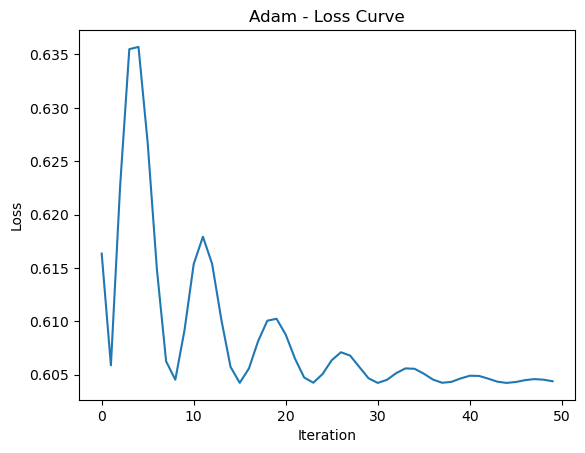

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import json
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

def load_data(filename):
    data = np.loadtxt(filename, delimiter=",", skiprows=1)
    X = data[:, :2]
    y = data[:, 2]
    return X, y


# ==========================================================
# Logistic Regression Functions
# ==========================================================
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(X, y, w):
    m = len(y)
    z = X @ w
    h = sigmoid(z)
    eps = 1e-8
    loss = -np.mean(y * np.log(h + eps) + (1 - y) * np.log(1 - h + eps))
    return loss


def compute_gradient(X, y, w):
    m = len(y)
    z = X @ w
    h = sigmoid(z)
    grad = (1/m) * X.T @ (h - y)
    return grad


# ==========================================================
# Optimizers
# ==========================================================

def gradient_descent(X, y, w_init, lr, epochs):
    w = w_init.copy()
    history = [w.copy()]
    losses = []

    for _ in range(epochs):
        grad = compute_gradient(X, y, w)
        w -= lr * grad
        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def stochastic_gradient_descent(X, y, w_init, lr, epochs):
    w = w_init.copy()
    history = [w.copy()]
    losses = []
    m = len(y)

    for _ in range(epochs):
        for i in range(m):
            xi = X[i:i+1]
            yi = y[i:i+1]
            grad = compute_gradient(xi, yi, w)
            w -= lr * grad

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def mini_batch_gradient_descent(X, y, w_init, lr, epochs, batch_size=4):
    w = w_init.copy()
    history = [w.copy()]
    losses = []
    m = len(y)

    for _ in range(epochs):
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            grad = compute_gradient(X_batch, y_batch, w)
            w -= lr * grad

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def nesterov(X, y, w_init, lr, epochs, gamma=0.9):
    w = w_init.copy()
    v = np.zeros_like(w)
    history = [w.copy()]
    losses = []

    for _ in range(epochs):
        lookahead = w - gamma * v
        grad = compute_gradient(X, y, lookahead)
        v = gamma * v + lr * grad
        w -= v

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def adagrad(X, y, w_init, lr, epochs):
    w = w_init.copy()
    G = np.zeros_like(w)
    eps = 1e-8
    history = [w.copy()]
    losses = []

    for _ in range(epochs):
        grad = compute_gradient(X, y, w)
        G += grad**2
        w -= (lr / (np.sqrt(G) + eps)) * grad

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def rmsprop(X, y, w_init, lr, epochs, beta=0.9):
    w = w_init.copy()
    E = np.zeros_like(w)
    eps = 1e-8
    history = [w.copy()]
    losses = []

    for _ in range(epochs):
        grad = compute_gradient(X, y, w)
        E = beta * E + (1 - beta) * grad**2
        w -= (lr / (np.sqrt(E) + eps)) * grad

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


def adam(X, y, w_init, lr, epochs, beta1=0.9, beta2=0.999):
    w = w_init.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    eps = 1e-8
    history = [w.copy()]
    losses = []

    for t in range(1, epochs+1):
        grad = compute_gradient(X, y, w)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2

        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        w -= lr * m_hat / (np.sqrt(v_hat) + eps)

        history.append(w.copy())
        losses.append(compute_loss(X, y, w))

    return np.array(history), losses


# ==========================================================
# Visualization Functions
# ==========================================================

def create_loss_surface(X, y, w_range=3):
    w1 = np.linspace(-w_range, w_range, 100)
    w2 = np.linspace(-w_range, w_range, 100)
    W1, W2 = np.meshgrid(w1, w2)

    Z = np.zeros_like(W1)

    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            w = np.array([W1[i,j], W2[i,j]])
            Z[i,j] = compute_loss(X, y, w)

    return W1, W2, Z


def animate_contour(W1, W2, Z, history, title):
    fig, ax = plt.subplots()
    contour = ax.contour(W1, W2, Z, levels=30)
    point, = ax.plot([], [], 'ro')

    def update(frame):
        point.set_data(history[frame,0], history[frame,1])
        return point,

    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=100)
    plt.title(title)
    plt.show()


def animate_3d(W1, W2, Z, history, X, y, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(W1, W2, Z, cmap='viridis', alpha=0.6)

    point, = ax.plot([], [], [], 'ro')

    def update(frame):
        w = history[frame]
        loss = compute_loss(X, y, w)
        point.set_data(w[0], w[1])
        point.set_3d_properties(loss)
        return point,

    ani = animation.FuncAnimation(fig, update, frames=len(history), interval=100)
    plt.title(title)
    plt.show()


def plot_loss_curve(losses, title):
    plt.figure()
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()


# ==========================================================
# Main Execution
# ==========================================================
if __name__ == "__main__":

    X, y = load_data(r"C:\Users\23adsb51\Downloads\csvjson.csv")

    w_init = np.array([0.5, -0.5])
    lr = 0.5
    epochs = 50

    W1, W2, Z = create_loss_surface(X, y)

    optimizers = {
        "Gradient Descent": gradient_descent,
        "SGD": stochastic_gradient_descent,
        "Mini-Batch GD": mini_batch_gradient_descent,
        "Nesterov": nesterov,
        "Adagrad": adagrad,
        "RMSProp": rmsprop,
        "Adam": adam
    }

    for name, optimizer in optimizers.items():
        print(f"Running {name}...")

        history, losses = optimizer(X, y, w_init, lr, epochs)

        animate_contour(W1, W2, Z, history, f"{name} - Contour")
        animate_3d(W1, W2, Z, history, X, y, f"{name} - 3D Surface")
        plot_loss_curve(losses, f"{name} - Loss Curve")

